<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Neural-Machine-Translation-NMT-with-attention/blob/main/20230113_MSc_DA_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system with an attention model.

This is an **individual assignment** and usual rules for plagiarism apply! With this you agree that: "In submitting this work I confirm that it is entirely my own. I acknowledge that I may be invited to online interview if there is any concern in relation to the integrity of my exam." 

**Write comments and documentation.**



## Mounting Drive and setting paths

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Changing the directory on file to access the files
%cd /content/drive/MyDrive/Colab Notebooks/NUIG/NLP/Assignment 2

/content/drive/MyDrive/Colab Notebooks/NUIG/NLP/Assignment 2


## Section 1- Data Collection and Preprocessing 


---


In [32]:
# Loading necessary libraries

import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model
from numpy import array
from numpy import asarray
from numpy import zeros
import nltk
from nltk import bigrams, trigrams, ngrams
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Activation, dot, concatenate, TimeDistributed

**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from the OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train, development and test set
*  Print 100th sentence in original script for source and target language


---
Language Selected: **English - Spanish**

Source: https://opus.nlpl.eu/ 

**Corpus: Tatoeba v2021-03-10 -- en(English) - es(Spanish)** 

NOTE: Downloaded zip file from moses link -> extracted files and renamed them to **Tatoeba - english.txt** and **Tatoeba - spanish.txt** 

---

In [4]:
# SOURCE Language : list of lines
with open("Tatoeba - english.txt" , 'r') as english_file:
  source = english_file.read().split('\n')         

# TARGET Language : list of lines
with open("Tatoeba - spanish.txt" , 'r') as spanish_file:
  target = spanish_file.read().split('\n')         

In [5]:
# Filter source sentences which have max length <=20
# This is done because google colab was crashing before due to very large number of sentences 
# resulting in very large tensors

index = []                   # index'es of the sentences which have sentence length <=20
source_lines = []            # The SOURCE sentence at the index 
target_lines = []            # The TARGET sentence at the index

# loop to append index'es 
for line in range(len(source)):
  if ((len(source[line]) >  0) and (len(source[line]) < 20) and (len(target[line]) >  0) and (len(target[line]) < 20)):
    index.append(line)
    if(len(index) == 10000):    # Break if 10K sentences are acquired
      break 

# loop to append the SOURCE and TARGET sentences
for line in index:
  source_lines.append(source[line])
  target_lines.append(target[line])

In [6]:
# Original number of sentences in SOURCE and TARGET files 
print("Source (English): Total Number of Sentences:", len(source))                        # 209468 sentences
print("Target (Spanish): Total Number of Sentences:", len(target))                        # 209468 sentences

print("\nSource (English): Filtered Number of Sentences:", len(source_lines))             # 10000 sentences                       
print("Target (Spanish): Filtered Number of Sentences:", len(target_lines))               # 10000 sentences

Source (English): Total Number of Sentences: 209468
Target (Spanish): Total Number of Sentences: 209468

Source (English): Filtered Number of Sentences: 10000
Target (Spanish): Filtered Number of Sentences: 10000


In [7]:
# Splitting the data into Train(90%) and tests(10%)
# will split the 90% Train into --> train(80%) and validation(10%) in model.fit()
X_train, X_test, y_train, y_test = train_test_split(source_lines, target_lines, test_size = 0.1)

# print(len(X_train), len(X_test)) --- (9000, 1000)

In [8]:
# Print 100th sentence in original SOURCE and TARGET files
print("\nSource (English): 100th Sentence: ", source_lines[99])
print("Target (Spanish): 100th Sentence: ", target_lines[99])


Source (English): 100th Sentence:  Where are you? 
Target (Spanish): 100th Sentence:  ¿Dónde están? 


---
**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the pre-processing step of the text.
* Print the last 5 sentences of the preprocessed text.
* Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language
  * Source Vocabulary
  * Target Vocabulary





In [9]:
# PREPROCESSING - function to remove punctuation characters
def punctuations(sentence):
  punct_chars = '''!()-[]{};:'"\,<>./¿?@#$%^&*_~+-'''

  # remove punctuation from the string
  no_punct = ""
  for char in sentence:
    if char not in punct_chars:
      no_punct = no_punct + char
  
  return(no_punct)

In [10]:
# Defining the SOURCE & TARGET sets to store the vocabulary of X_train and y_train
source_vocab = set()
target_vocab = set()

# Pre-processing the SOURCE and TARGET sentences for the original lines
# Converting to lowercase
source_lines = [line.lower() for line in X_train]
target_lines = [line.lower() for line in y_train]

# removing punctuations
source_lines = [punctuations(line) for line in source_lines]
target_lines = [punctuations(line) for line in target_lines]

# Adding '<bof>' to denote beginning of sentence and '<eos>' to denote the end of the sentence to each target line.
target_lines = ['<bof> ' + target + ' <eos>' for target in target_lines]

# creating the vocab set for SOURCE
for line in source_lines:
  words_per_line = line.split()
  for word in words_per_line:
    if word not in source_vocab:
      source_vocab.add(word)

# creating the vocab set for TARGET
for line in target_lines:
  words_per_line = line.split()
  for word in words_per_line:
    if word not in target_vocab:
      target_vocab.add(word)

In [11]:
# Last 5 sentences after preprocessing
# SOURCE lines
print("Last 5 sentences from preprocessed SOURCE")
i = 4
for line in source_lines[-5:]:
  print("sentence ", len(source_lines)-i, ": ", line)
  i-=1

# TARGET lines
print("\nLast 5 sentences from preprocessed TARGET")
i = 4
for line in target_lines[-5:]:
  print("sentence ", len(target_lines)-i, ": ", line)
  i-=1 

Last 5 sentences from preprocessed SOURCE
sentence  8996 :  i want a bath 
sentence  8997 :  its cold today 
sentence  8998 :  i will shoot him 
sentence  8999 :  youre my hero 
sentence  9000 :  its done 

Last 5 sentences from preprocessed TARGET
sentence  8996 :  <bof> quiero un baño  <eos>
sentence  8997 :  <bof> ¡hoy hace frío  <eos>
sentence  8998 :  <bof> le voy a disparar  <eos>
sentence  8999 :  <bof> eres mi héroe  <eos>
sentence  9000 :  <bof> ¡listo  <eos>


In [12]:
# Statistics of the dataset -- Reference Lab 8
# SOURCE and TARGET vocabulary as sorted list 
source_vocab = sorted(list(source_vocab))            
target_vocab = sorted(list(target_vocab))

# Number of Encoder and Decoder tokens
len_source_vocab = len(source_vocab)                # 2462 tokens
len_target_vocab = len(target_vocab)                # 4387 tokens

# Max sequence length for Encoder and Decoder
max_seq_len_source = max([len(txt) for txt in source_lines])      # 18
max_seq_len_target = max([len(txt) for txt in target_lines])      # 30

print('Number of samples\t\t\t:', len(source_lines))
print('Number of unique SOURCE language tokens\t:', len_source_vocab)
print('Number of unique TARGET language tokens\t:', len_target_vocab)
print('Max sequence length of SOURCE language\t:', max_seq_len_source)
print('Max sequence length of TARGET language\t:', max_seq_len_target)
print("Source Vocabulary\t\t\t:",source_vocab)
print("Target Vocabulary\t\t\t:",target_vocab)

Number of samples			: 9000
Number of unique SOURCE language tokens	: 2462
Number of unique TARGET language tokens	: 4387
Max sequence length of SOURCE language	: 18
Max sequence length of TARGET language	: 30
Source Vocabulary			: ['1', '10', '100', '12', '18', '19', '2', '24', '25', '50', '7', 'a', 'abandon', 'abating', 'abducted', 'abide', 'able', 'aboard', 'about', 'above', 'absent', 'absolutely', 'absurd', 'accelerated', 'accept', 'ache', 'aching', 'achoo', 'acrophobia', 'act', 'action', 'actor', 'actors', 'add', 'addicted', 'adjust', 'admire', 'admired', 'admission', 'adopted', 'adorable', 'adore', 'adults', 'advance', 'advice', 'affair', 'afraid', 'after', 'afternoon', 'afterward', 'again', 'age', 'ages', 'aggressive', 'ago', 'agree', 'ah', 'ahead', 'ahhh', 'ahoy', 'aids', 'ails', 'aim', 'airplane', 'alan', 'alarm', 'alas', 'alcohol', 'alert', 'alex', 'alice', 'alive', 'all', 'allah', 'allan', 'allen', 'almost', 'alone', 'along', 'aloud', 'already', 'alright', 'also', 'always', '

**Task 3 (15 marks)** 

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained embeddings, for example GloVe or fastText (10 marks) (https://nlp.stanford.edu/projects/glove/ , https://fasttext.cc/docs/en/english-vectors.html)
* Print the first line of the embeddings (see below) 

In [13]:
# Assigning each word/token an integer value for both SOURCE and TARGET 
source_vocab_index = dict([(word,i) for i, word in enumerate(source_vocab)])                  # 2462 tokens --- same as above
target_vocab_index = dict([(word,i) for i, word in enumerate(target_vocab)])                  # 4387 tokens --- same as above

Tried using various fastText word-embedding(smallest: "wiki-news-300d-1M.vec.zip") but the session always crashed after using all the available RAM on google colab.

Thus using GloVe word-embedding --- Reference from Lab 2

In [14]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [15]:
path_to_glove_file = "/content/drive/MyDrive/Embeddings/GloVe/glove.6B.300d.txt"

glove_embeddings = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

In [17]:
# Creating our own word-embedding from the pre-trained GloVe embedding

# Embedding Shape - 300 - because the pretrained model selected has 300 dimensions
# glove_embeddings['the'].shape
embedding_shape = 300
# source_embedding shape : (2580, 200) --- (source_tokens, vector dimensions)
source_embedding = zeros((len(source_vocab_index), embedding_shape))

# for every source token present in GloVe embedding
# extract the vector and assign it to our own word-embedding
for word, index in source_vocab_index.items():
  try:
    vector = glove_embeddings[word]
    source_embedding[index] = vector
  except:
    continue

In [18]:
# Printing First line of embedding
print(source_embedding[0])

[-2.86769986e-01  1.22570001e-01  2.42209993e-02  4.07350004e-01
 -4.48210001e-01  7.32349977e-02 -9.80560035e-02  3.57369989e-01
  4.87350002e-02 -1.05470002e+00  7.07840025e-01  3.11280012e-01
  5.99430017e-02  5.30600011e-01 -4.11579991e-03  4.27199990e-01
 -3.06369990e-01  1.53099999e-01 -3.58009994e-01 -3.45400006e-01
 -3.51500005e-01 -3.94410014e-01  1.47429993e-04  1.02849998e-01
 -1.02200001e-01  1.43830001e-01 -1.93800002e-01 -1.31219998e-01
 -4.26800013e-01 -5.49809992e-01 -5.20900011e-01  4.34170008e-01
  5.72960004e-02  3.81639987e-01 -1.24979997e+00  1.11709997e-01
  3.37190002e-01  5.81290007e-01 -3.85199994e-01  1.02820002e-01
  1.78220004e-01 -3.29869986e-01 -4.63510007e-01  9.18649971e-01
 -1.91689998e-01 -1.90870002e-01  6.01069987e-01  5.15559971e-01
 -2.71519989e-01  1.22309998e-01 -1.12980001e-01  1.20660000e-01
 -5.50090015e-01  8.71890008e-01 -1.91349998e-01 -1.15879998e-01
  1.15450002e-01 -3.15109998e-01  4.06069994e-01 -4.43120003e-01
  4.93649989e-02  8.57139

## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [19]:
# encoder input data : each source line (10K) is considered having sentence length = having max sentence length(18) 
# which is filled with 1-hot encoded tokens(2580)
encoder_input_data   = np.zeros((len(source_lines), max_seq_len_source), dtype='float32')

# decoder input data : each target line (10K) is considered having sentence length = having max sentence length(30) 
# which is filled with 1-hot encoded tokens(4650)
decoder_input_data   = np.zeros((len(source_lines), max_seq_len_target), dtype='float32')

# decoder target data : each target line (10K) is considered having sentence length = having max sentence length(30) 
# which is filled with 1-hot encoded tokens(4650)
decoder_target_data  = np.zeros((len(source_lines), max_seq_len_target, len_target_vocab), dtype='float32')

In [20]:
# One- hot encoding
for line_index, (source_indv_line, target_indv_line) in enumerate(zip(source_lines, target_lines)):
  for token_index, token in enumerate((source_indv_line).split()):
    encoder_input_data[line_index, token_index] = source_vocab_index[token]

  for token_index, token in enumerate((target_indv_line).split()):
    decoder_input_data[line_index, token_index] = target_vocab_index[token]

    if(token_index > 0):
      decoder_target_data[line_index, token_index - 1, target_vocab_index[token]] = 1

print("Encoder_input_data shape: ", encoder_input_data.shape, ",\nsample: ", encoder_input_data[1])
print("\nDecoder_input_data shape: ", decoder_input_data.shape, ",\nsample: ", decoder_input_data[1])
print("\nDecoder_output_data shape: ", decoder_target_data.shape, ",\nsample: ", decoder_target_data[1])

Encoder_input_data shape:  (9000, 18) ,
sample:  [1116.  973. 1911.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.]

Decoder_input_data shape:  (9000, 30) ,
sample:  [  10. 1511. 1212.   11.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.]

Decoder_output_data shape:  (9000, 30, 4387) ,
sample:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Training Seq2Seq model

In [21]:
epochs          = 200 
batch_size      = 200
latent_dim      = 256
embedding_shape = 300

In [22]:
# Defining Encoder Architecture
encoder_input    = Input(shape = (max_seq_len_source,), name = 'Encoder_input')
embedded_encoder = Embedding(len_source_vocab, embedding_shape, weights=[source_embedding], mask_zero=True)(encoder_input)
encoder_output, state_h, state_c = LSTM(latent_dim, return_state=True)(embedded_encoder)
encoder_state = [state_h,state_c]

In [23]:
# Defining Decoder Architecture
decoder_input    = Input(shape = (max_seq_len_target,), name = 'Decoder_input')
embedded_decoder = Embedding(len_target_vocab, latent_dim,  mask_zero=True)(decoder_input)
decoder_output, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(embedded_decoder, initial_state = encoder_state)

# Using Softmax activation
decoder_dense = Dense(len_target_vocab, activation='softmax', name = 'Decoder_Dense')
decoder_output = decoder_dense(decoder_output)

In [24]:
model = Model(inputs = [encoder_input, decoder_input], outputs = decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 18)]         0                                            
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 300)      738600      Encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 256)      1123072     Decoder_input[0][0]              
______________________________________________________________________________________________

In [30]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

# Callback to stop training the model when the validation loss has stopped improving
early = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')

# Fitting the model
model_history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                          batch_size = batch_size , epochs = epochs, validation_split=0.12,
                          callbacks=[early])

model.save('seq2seq_source_target.h5')

Epoch 1/200
40/40 [==============================] - 34s 628ms/step - loss: 0.5928 - accuracy: 0.2629 - val_loss: 0.5916 - val_accuracy: 0.2779
Epoch 2/200
40/40 [==============================] - 22s 544ms/step - loss: 0.5391 - accuracy: 0.2904 - val_loss: 0.5617 - val_accuracy: 0.3037
Epoch 3/200
40/40 [==============================] - 22s 548ms/step - loss: 0.4962 - accuracy: 0.3129 - val_loss: 0.5310 - val_accuracy: 0.3188
Epoch 4/200
40/40 [==============================] - 21s 536ms/step - loss: 0.4596 - accuracy: 0.3329 - val_loss: 0.5075 - val_accuracy: 0.3323
Epoch 5/200
40/40 [==============================] - 22s 545ms/step - loss: 0.4218 - accuracy: 0.3509 - val_loss: 0.4865 - val_accuracy: 0.3486
Epoch 6/200
40/40 [==============================] - 22s 548ms/step - loss: 0.3902 - accuracy: 0.3706 - val_loss: 0.4674 - val_accuracy: 0.3612
Epoch 7/200
40/40 [==============================] - 22s 551ms/step - loss: 0.3625 - accuracy: 0.3839 - val_loss: 0.4601 - val_accuracy:

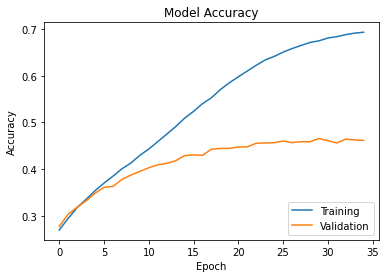

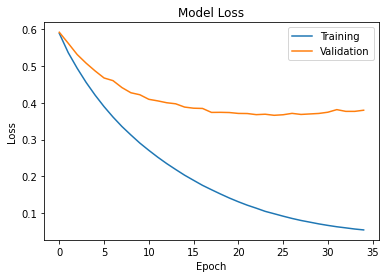

In [33]:
# list all data in history
# print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [ ]:
#Your code goes here

# Section 4 Attention

---



**Task 5 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

In [ ]:
#Your code goes here